## Part 3.4 
Keeping the above two adjustments, replace your simple RNN model in Part 2 with a Convolutional Neural Network (CNN) to produce sentence representations and perform sentiment
classification.

In [1]:
from datasets import load_dataset
from utils.rnn_model import *
from utils.rnn_utils import *
from dotenv import load_dotenv
import os

load_dotenv()

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\glend\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\glend\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\glend\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [2]:
dataset = load_dataset("rotten_tomatoes")
trn_dataset = dataset["train"]
val_dataset = dataset["validation"]
tst_dataset = dataset["test"]

In [3]:
# Obtain a list of unique words from the train set

sentences = trn_dataset["text"]
words = []

for i in range(len(sentences)):
    sentences[i] = simple_preprocess(sentences[i])

for sentence in sentences:
    for word in sentence:
        if word not in words:
            words.append(word)

# Pass it in to the load_word2vec function along w the relative filepath of the embedding file
word2vec_model = load_word2vec(vocab=words, filepath=r"data\embedding_matrix_oov.npy")

In [4]:
word_index = {
    word: i for i, word in enumerate(
        word2vec_model.index_to_key
    )
}

Dataloaders

In [5]:
trn_sentences, trn_labels = prepare_data(
    trn_dataset["text"],
    trn_dataset["label"],
    word_index=word_index
)
val_sentences, val_labels = prepare_data(
    val_dataset["text"],
    val_dataset["label"],
    word_index=word_index
)
tst_sentences, tst_labels = prepare_data(
    tst_dataset["text"],
    tst_dataset["label"],
    word_index=word_index
)

In [6]:
BATCH_SIZE = 32

trn_dataloader = create_dataloader(
    trn_sentences,
    trn_labels,
    BATCH_SIZE,
    shuffle=True)
val_dataloader = create_dataloader(
    val_sentences,
    val_labels,
    BATCH_SIZE,
    shuffle=False)
tst_dataloader = create_dataloader(
    tst_sentences,
    tst_labels,
    BATCH_SIZE,
    shuffle=False)

## Model

In [7]:
model = CNNModel(
    embedding_dim=300,
    embedding_matrix=word2vec_model.vectors,
    freeze_embeddings=False,  # Set to False to make embeddings trainable
)

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

def train_cnn(
    trn_dataloader,
    val_dataloader,
    optimizer,
    version,
    model_save_path,
    model_type,
    epochs=10,
    criterion=nn.BCELoss(),
    early_stopping_patience=5,
    load_best_model_at_end=True
):
    """
    Train a CNN model using the provided training and validation dataloaders.
    Args:
        trn_dataloader (torch.utils.data.DataLoader): DataLoader for the training data.
        val_dataloader (torch.utils.data.DataLoader): DataLoader for the validation data.
        optimizer (torch.optim.Optimizer): Optimizer for updating the model parameters.
        version (str): Version identifier for saving the model.
        model_save_path (str): Path to save the trained model.
        model_type (str): Type of the model, used in the filename when saving.
        epochs (int, optional): Number of epochs to train the model. Default is 10.
        criterion (torch.nn.Module, optional): Loss function. Default is nn.BCELoss().
        early_stopping_patience (int, optional): Number of epochs with no improvement 
                                                 after which training will be stopped. Default is 5.
        load_best_model_at_end (bool, optional): Whether to load the best model at the end of training. Default is True.
    Returns:
        tuple: A tuple containing:
            - losses (list of float): List of loss values for each epoch.
            - accuracies (list of float): List of accuracy values for each epoch.
    """
    create_directory(model_save_path)
    
    train_losses = []
    val_accuracies = []
    best_accuracy = 0
    patience_counter = 0  # Counter for early stopping

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        # Training loop
        for X_batch, y_batch in tqdm(trn_dataloader, desc=f"Epoch {epoch + 1}/{epochs}", unit="batch"):
            optimizer.zero_grad()

            # Forward pass
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(trn_dataloader)
        train_losses.append(avg_loss)

        # Validation step
        val_accuracy = validate(model, val_dataloader)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch + 1}/{epochs}, Training Loss: {avg_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

        # Save model if validation accuracy improves
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            patience_counter = 0  # Reset patience counter
            filepath = f"{model_save_path}{model_type}_v{version}.pth"
            save_model(model, filepath)
        else:
            patience_counter += 1

        # Early stopping
        if patience_counter >= early_stopping_patience:
            print(f"Early stopping triggered after {epoch + 1} epochs.")
            break

    # Load the best model if specified
    if load_best_model_at_end:
        print("Training ended, loading best model...")
        load_model(model, filepath)

    return train_losses, val_accuracies

In [9]:
train_losses, val_accuracies = train_cnn(
    trn_dataloader=trn_dataloader,
    val_dataloader=val_dataloader,
    optimizer=torch.optim.Adam(model.parameters(), lr=0.0001),
    version="1.0",
    model_save_path="./models/",
    model_type="cnn",
    epochs=10,
    criterion=nn.BCELoss(),
    early_stopping_patience=5,
    load_best_model_at_end=True
)


Epoch 1/10: 100%|██████████| 267/267 [00:13<00:00, 20.39batch/s]


Accuracy: 0.5563
Epoch 1/10, Training Loss: 0.6939, Validation Accuracy: 0.5563
Model saved.


Epoch 2/10: 100%|██████████| 267/267 [00:18<00:00, 14.61batch/s]


Accuracy: 0.5675
Epoch 2/10, Training Loss: 0.6675, Validation Accuracy: 0.5675
Model saved.


Epoch 3/10: 100%|██████████| 267/267 [00:21<00:00, 12.14batch/s]


Accuracy: 0.5872
Epoch 3/10, Training Loss: 0.6507, Validation Accuracy: 0.5872
Model saved.


Epoch 4/10: 100%|██████████| 267/267 [00:19<00:00, 13.62batch/s]


Accuracy: 0.6051
Epoch 4/10, Training Loss: 0.6291, Validation Accuracy: 0.6051
Model saved.


Epoch 5/10: 100%|██████████| 267/267 [00:12<00:00, 20.78batch/s]


Accuracy: 0.6238
Epoch 5/10, Training Loss: 0.6065, Validation Accuracy: 0.6238
Model saved.


Epoch 6/10: 100%|██████████| 267/267 [00:12<00:00, 21.43batch/s]


Accuracy: 0.6417
Epoch 6/10, Training Loss: 0.5802, Validation Accuracy: 0.6417
Model saved.


Epoch 7/10: 100%|██████████| 267/267 [00:12<00:00, 21.56batch/s]


Accuracy: 0.6557
Epoch 7/10, Training Loss: 0.5500, Validation Accuracy: 0.6557
Model saved.


Epoch 8/10: 100%|██████████| 267/267 [00:13<00:00, 20.06batch/s]


Accuracy: 0.6585
Epoch 8/10, Training Loss: 0.5144, Validation Accuracy: 0.6585
Model saved.


Epoch 9/10: 100%|██████████| 267/267 [00:12<00:00, 21.44batch/s]


Accuracy: 0.6773
Epoch 9/10, Training Loss: 0.4772, Validation Accuracy: 0.6773
Model saved.


Epoch 10/10: 100%|██████████| 267/267 [00:12<00:00, 20.59batch/s]


Accuracy: 0.6961
Epoch 10/10, Training Loss: 0.4355, Validation Accuracy: 0.6961
Model saved.
Training ended, loading best model...
Model loaded.


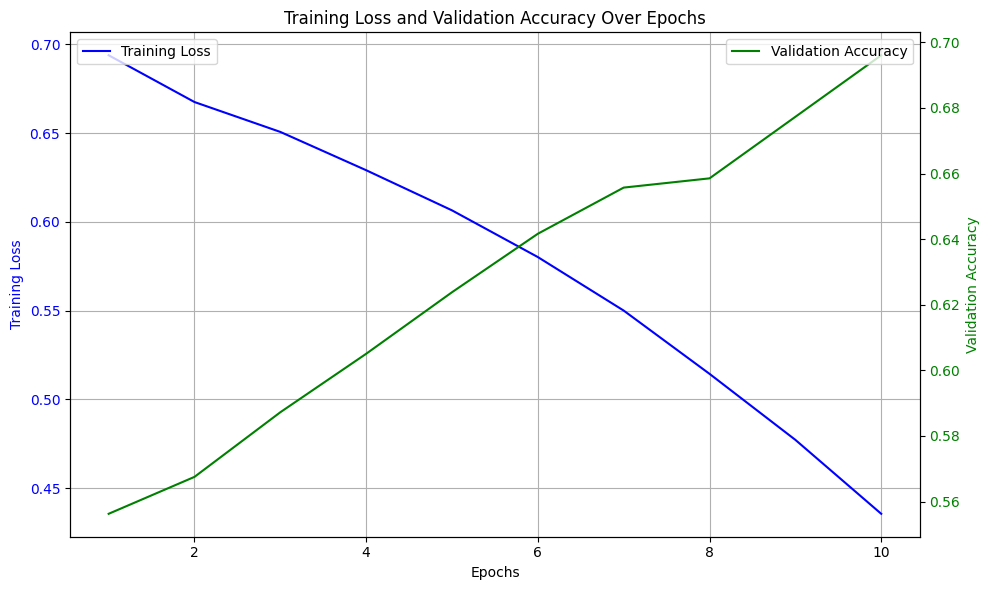

In [10]:
plot_training_progress(train_losses, val_accuracies)